In [930]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### VISUALIZE AND QUANTIZE 

In [931]:
"""
Cell Purpose: Load all the gesture training data and append it to two variables

Variable: 
- time_data: "Specific times that acceleration was observed"
- acceleration_data: "Specific linear and angular acceleration at specific times"

Variable Shapes: 
- time_data = (4111, 1) = (# instances, 1 Time)
- acceleration_data = (4111, 6) = (# Instances, 6 acceleration columns)
"""

def load_file(file_name):
    return np.loadtxt(file_name)

fname = "Data/ECE5242Proj2_train_additional-selected/wave31.txt"
gesture_data = load_file(fname)
time_data = gesture_data[:, 0][:, np.newaxis]
acceleration_data = gesture_data[:, 1:]

# # Append all of the gesture data which we will discretize the data 
# for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
#     fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
#     path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
#     gesture_data = load_file(path)

#     if i == 0:
#         time_data = gesture_data[:, 0][:, np.newaxis]
#         acceleration_data = gesture_data[:, 1:]
#     else:
#         time_data = np.row_stack((time_data, gesture_data[:, 0][:, np.newaxis])) # NOT SURE IF THIS IS CORRECT
#         acceleration_data = np.row_stack((acceleration_data, gesture_data[:, 1:]))

print(acceleration_data.shape, time_data.shape)

(441, 6) (441, 1)


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


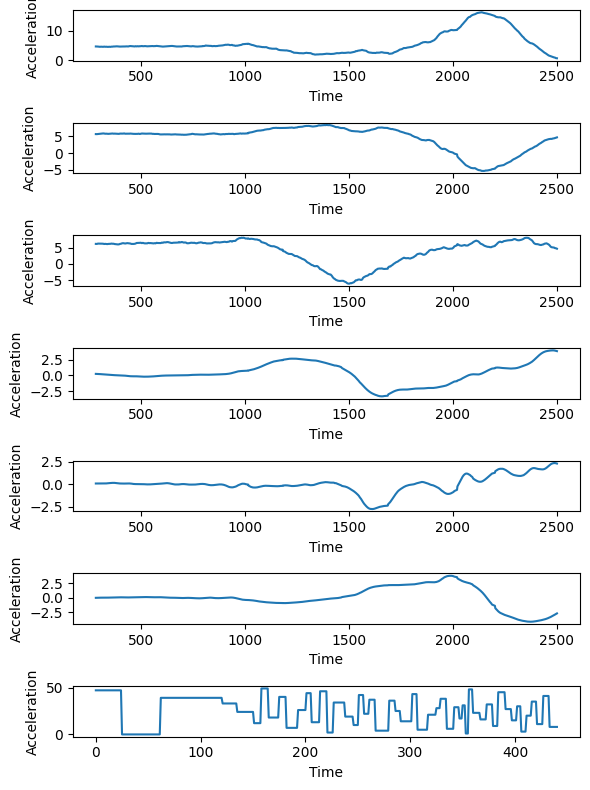

In [932]:
"""
Cell Purpose: Use KMeans to discretize the raw sensor data which is seen in the last graph. 

Variables:
- num_of_clusters = "using kmeans to create clusters which brings down the number of dimensions from 6 to 1"
- M = "discrete observations or KMeans clusters"
- O = "Observations"

Variable Shapes:
- num_of_clusters = float

"""
def plot_continuous_discrete(clusters, time, acceleration):
    # Plot the data
    fig, axs = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(6, 8))

    # Plot each channel in a separate subplot
    for i, ax in enumerate(axs):
        if i < 6:
            ax.plot(time, acceleration[:, i])
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
        else:
            ax.plot(clusters)
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')

    # # Adjust the layout and spacing of the subplots
    fig.tight_layout()

    # Show the plot
    plt.show()


M = 50
O = KMeans(n_clusters=M).fit_predict(acceleration_data)
plot_continuous_discrete(O, time_data, acceleration_data)

## IMPLEMENT HMM

In [933]:
"""
Cell Purpose: Initialize the model parameters

Variables:
- N: Number of states
- M: Number of observation classes or clusters
- A: Transition Matrix
- pi: Initial probability we are in a a specific state

Variable Shapes
- N: float
- A: (Number of states, number of states)
- pi: (N, 1)
"""

def init_a_matrix(N):
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 0.5
        if i + 1 < N:
            A[i + 1, i] = 0.5
    
    A[0, -1] = 0.5 # This is to make sure it can transition to another state
    return A

def init_pi_matrix(N):
    pi = np.zeros((N))
    pi[0] = 1
    return pi

def init_b_matrix(N, M):
    arr = np.random.rand(N, M)
    arr = arr / np.sum(arr, axis=1, keepdims=True)
    return arr

N = 10
A = init_a_matrix(N)
B = init_b_matrix(N, M)
pi = init_pi_matrix(N)

print("\nA: ", A)
print("\nB: ", B)
print("\nPi: ", pi)
# print("\nO: ", O)


A:  [[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]

B:  [[0.03165187 0.00735498 0.03677274 0.01193368 0.0328453  0.00528517
  0.00586236 0.02737992 0.01930699 0.03547433 0.03146693 0.00550203
  0.02135697 0.01103019 0.00383462 0.01103707 0.02349657 0.0120942
  0.01592186 0.03372052 0.02773923 0.01281074 0.02128791 0.02284486
  0.01614264 0.01724938 0.00304823 0.0247188  0.01146205 0.03325432
  0.03149511 0.01379672 0.024704   0.0143201  0.0221103  0.02325348
  0.0326415  0.01450167 0.02171289 0.00522482 0.01998297 0.00615183
  0.0343697  0.00828453 0.0304612  0.03277642 0.03037095 0.00091923
  0.03658952 0.0

In [947]:
"""
Variables:
- O: "Each observation is assigned a cluster number which also indicates"
- B: "Observation/Emission Matrix"
- pi: "Initial state probabilities"
- Alpha: "Probability you are in state j given a sequence of observations up to t-1"
- Beta: "Probability of seeing a sequence of future observations"
- A: "Transition Matrix"
- Gamma: "Probability of being in state i at time T"
- xi: "Probability of going from state i to state j given observation sequence"
- c: "Scaling factor to prevent underflow"


Variable Shapes:
- O: (4111,) = (Gesture Instances, 1)
- B: (10 , 50) = (Number of hidden states, Number of clusters)
- pi: (10, 1) = (Number of hidden states, 1)
- Alpha: ( Length of the observation sequence, Number of hidden states)
- Beta: (Length of observation sequence, Number of hidden states)
- A: (Number of hidden states, number of hidden states))
- Gamma: (Number of hidden states, Length of observation sequence)
- xi: (Number of hidden states, Number of hidden states, Length of observation sequence)
- c: (Length of observation sequence)
"""

class HMM:
    def __init__(self, N, M, A, B, pi, O):
        self.N = N
        self.M = M
        self.A = A
        self.B = B
        self.pi = pi
        self.O = O
        self.T = len(O)
        
    def forward(self):
        alpha = np.zeros((self.T, self.N))
        c = np.zeros(self.T)
        
        # Base case
        alpha[0, :] = self.pi.flatten() * self.B[:, self.O[0]]
        c[0] = 1 / (np.sum(alpha[0]) + 1e-8) 
        alpha[0, :] *= c[0]
        
        # Recursive case
        for t in range(1, self.T):
            alpha[t, :] = np.sum(alpha[t-1, :].reshape((-1, 1)) * self.A, axis=0) * self.B[:, self.O[t]] # Double check reshapes if it doesn't work
            c[t] = 1 / (np.sum(alpha[t]) + 1e-8)
            alpha[t, :] *= c[t]
            
        return alpha, c
        
    def backward(self, c):
        beta = np.zeros((self.T, self.N))
        
        # Base case
        beta[-1, :] = 1
        beta[-1, :] *= c[-1]
        
        # Recursive case
        for t in range(self.T-2, -1, -1):
            beta[t, :] = np.sum(self.A * self.B[:, self.O[t+1]] * beta[t+1, :], axis=1)
            beta[t, :] *= c[t]
            
        return beta
    
    def calculate_gamma(self, alpha, beta):
        gamma = alpha * beta
        gamma /= (np.sum(gamma, axis=1, keepdims=True) + 1e-8)
        return gamma

    def calculate_xi(self, alpha, beta):
        xi = np.zeros((self.T-1, self.N, self.N))
        for t in range(self.T-1):
            xi[t, :, :] = alpha[t, :].reshape((-1, 1)) * self.A * self.B[:, self.O[t+1]].reshape((1, -1)) * beta[t+1, :].reshape((1, -1)) # Double check reshapes if it doesn't work
            xi[t, :, :] /= (np.sum(xi[t, :, :]) + 1e-8)
        return xi
    
    def adjust_a(self, xi):
            A_hat = np.sum(xi, axis=0)
            A_hat /= (np.sum(A_hat, axis=1, keepdims=True) + 1e-8)
            return A_hat
    
    def adjust_b(self, gamma):
        B_hat = np.zeros((self.N, self.M))
        for j in range(self.N):
            for k in range(self.M):
                mask = (self.O == k)
                B_hat[j, k] = np.sum(gamma[mask, j]) / (np.sum(gamma[:, j]) + 1e-8)
        return B_hat
    
    def adjust_pi(self, gamma):
        pi_hat = gamma[0, :]
        pi_hat /= np.sum(pi_hat)
        return pi_hat

    def Baum_Welsh(self):
        # Forward and Backward
        alpha, c = self.forward()
        beta = self.backward(c)
        
        # E Step
        gamma = self.calculate_gamma(alpha, beta)
        xi = self.calculate_xi(alpha, beta)
        
        # M Step
        A_hat = self.adjust_a(xi)
        B_hat = self.adjust_b(gamma)
        pi_hat = self.adjust_pi(gamma)
        
        # Calculate likelihood
        log_likelihood = -np.sum(np.log(c))

        return A_hat, B_hat, pi_hat, log_likelihood


Epoch:  0

Log likelihood:  -1695.941603892385

Epoch:  1

Log likelihood:  -1311.3117782248048

Epoch:  2

Log likelihood:  -1085.0622853895027

Epoch:  3

Log likelihood:  -1049.9366583111694

Epoch:  4

Log likelihood:  -1037.4856605927187

Epoch:  5

Log likelihood:  -1030.80875911003

Epoch:  6

Log likelihood:  -1027.0980522367108

Epoch:  7

Log likelihood:  -1024.7290625253709

Epoch:  8

Log likelihood:  -1023.0211978010657

Epoch:  9

Log likelihood:  -1021.7116183845974


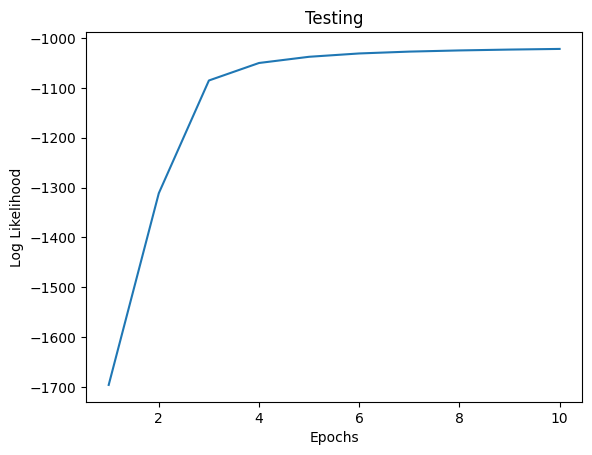

(array([[0.70751709, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.29248291],
        [0.19829053, 0.80170947, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.24543925, 0.75456075, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.35352255, 0.64647745, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.3143685 , 0.6856315 ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.29980969,
         0.70019031, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.1549358 , 0.8450642 , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [948]:
def plot_likelihoods(gesture_name, num_epochs, likelihoods):
    # Create a list of epoch numbers
    epochs = range(1, num_epochs+1)
    
    # Create a figure for subplots
    fig, axs = plt.subplots()
    axs.plot(epochs, likelihoods)
    axs.set_title(gesture_name)
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Log Likelihood')

    plt.show()


def train_model(gesture_name, epochs, N, M, A, B, pi, O):
    model = HMM(N, M, A, B, pi, O)
    log_likelihood_list = []
    for epoch in range(epochs):
        # print("Before A: ", model.A)
        # print("Before B: ", B)
        # print("pi: ", pi)
        A, B, pi, likelihood = model.Baum_Welsh()
        # print("After A: ", A)
        # print("After B: ", B)
        # print("pi: ", pi)
        model.A = A
        model.B = B
        model.pi = pi
        log_likelihood_list.append(likelihood)
        print("\nEpoch: ", epoch)
        print("\nLog likelihood: ", likelihood)
    
    plot_likelihoods(gesture_name, epochs, log_likelihood_list)
    return model.A, model.B, model.pi

# TESTING DATASET
# N = 2
# M = 2
# A = np.array([[0.5,0.5],[0.5,0.5]])
# B = np.array([[0.5,0.5],[0.5,0.5]])
# pi = init_pi_matrix(N)
# O = np.array([0,0,0,1,1,1])

train_model("Testing", 10, N, M, A, B, pi, O)

## TESTING

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Epoch:  0

Log likelihood:  -2417.330117065625

Epoch:  1

Log likelihood:  -1545.9801245639196

Epoch:  2

Log likelihood:  -1242.2347181326918

Epoch:  3

Log likelihood:  -1188.9593359597113

Epoch:  4

Log likelihood:  -1156.2469396988995

Epoch:  5

Log likelihood:  -1140.2781366527518

Epoch:  6

Log likelihood:  -1136.856675913854

Epoch:  7

Log likelihood:  -1135.0673317033763

Epoch:  8

Log likelihood:  -1134.2155502321539

Epoch:  9

Log likelihood:  -1133.6711334927331


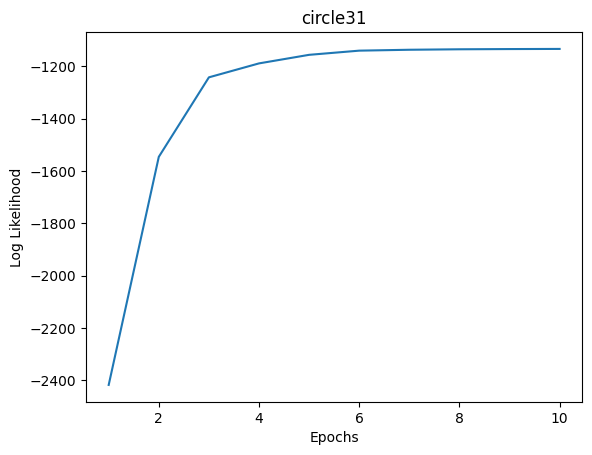

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Epoch:  0

Log likelihood:  -2896.5156745152262

Epoch:  1

Log likelihood:  -1839.7094954196473

Epoch:  2

Log likelihood:  -1544.634726592501

Epoch:  3

Log likelihood:  -1477.4750731080023

Epoch:  4

Log likelihood:  -1459.5432803750148

Epoch:  5

Log likelihood:  -1449.4786692127534

Epoch:  6

Log likelihood:  -1412.3161696793638

Epoch:  7

Log likelihood:  -1408.9573671073708

Epoch:  8

Log likelihood:  -1407.5604190531685

Epoch:  9

Log likelihood:  -1406.338380429178


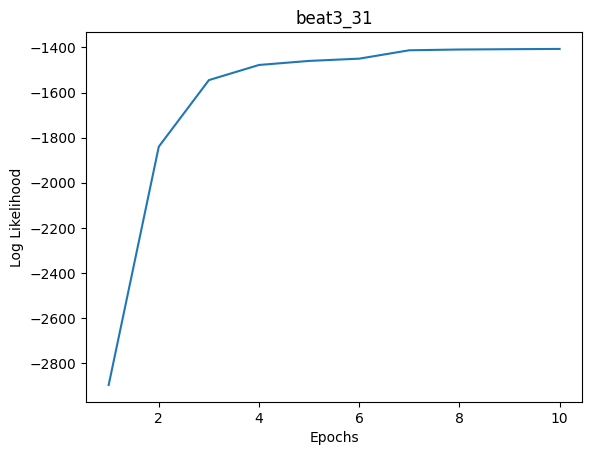

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Epoch:  0

Log likelihood:  -3359.007940379416

Epoch:  1

Log likelihood:  -2243.269518280517

Epoch:  2

Log likelihood:  -1903.8590472261712

Epoch:  3

Log likelihood:  -1782.3376516262908

Epoch:  4

Log likelihood:  -1757.4730778945764

Epoch:  5

Log likelihood:  -1749.093381647787

Epoch:  6

Log likelihood:  -1743.3936249427334

Epoch:  7

Log likelihood:  -1740.1036071299786

Epoch:  8

Log likelihood:  -1738.035079102127

Epoch:  9

Log likelihood:  -1736.776223128793


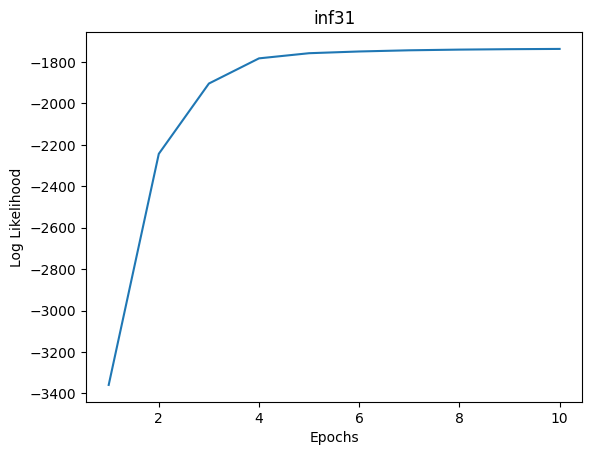

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Epoch:  0

Log likelihood:  -3354.2553751835976

Epoch:  1

Log likelihood:  -2068.636794289498

Epoch:  2

Log likelihood:  -1713.4194150202554

Epoch:  3

Log likelihood:  -1662.5348481039553

Epoch:  4

Log likelihood:  -1646.0910012876986

Epoch:  5

Log likelihood:  -1608.0622619627195

Epoch:  6

Log likelihood:  -1600.951448239731

Epoch:  7

Log likelihood:  -1599.559217593496

Epoch:  8

Log likelihood:  -1598.738100964971

Epoch:  9

Log likelihood:  -1598.1826215803083


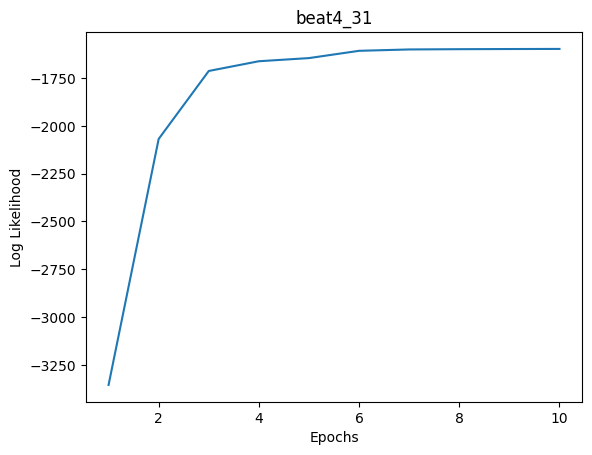

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Epoch:  0

Log likelihood:  -2315.380463436283

Epoch:  1

Log likelihood:  -1658.6722932118887

Epoch:  2

Log likelihood:  -1455.796538346308

Epoch:  3

Log likelihood:  -1387.916732862217

Epoch:  4

Log likelihood:  -1366.0792036089151

Epoch:  5

Log likelihood:  -1360.9132384339346

Epoch:  6

Log likelihood:  -1356.9514541991755

Epoch:  7

Log likelihood:  -1354.8949195799566

Epoch:  8

Log likelihood:  -1353.9294237590282

Epoch:  9

Log likelihood:  -1353.171956029113


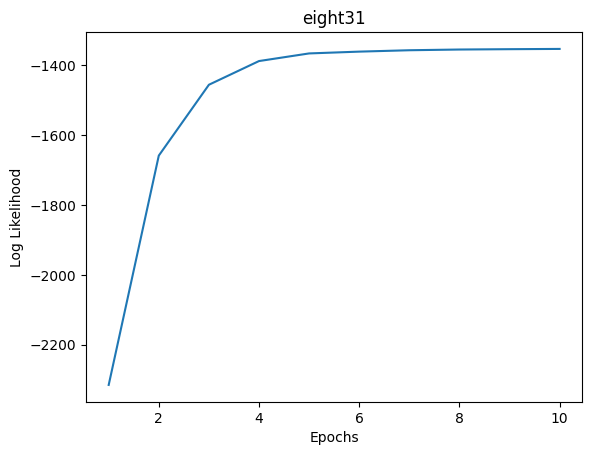


Epoch:  0

Log likelihood:  -1686.2533662126611


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Epoch:  1

Log likelihood:  -1276.656279027342

Epoch:  2

Log likelihood:  -1110.3247771806703

Epoch:  3

Log likelihood:  -1004.9285331292483

Epoch:  4

Log likelihood:  -996.0009018958455

Epoch:  5

Log likelihood:  -992.2053554307095

Epoch:  6

Log likelihood:  -989.8367892740238

Epoch:  7

Log likelihood:  -988.1957996437508

Epoch:  8

Log likelihood:  -986.7297472596076

Epoch:  9

Log likelihood:  -985.2133646918235


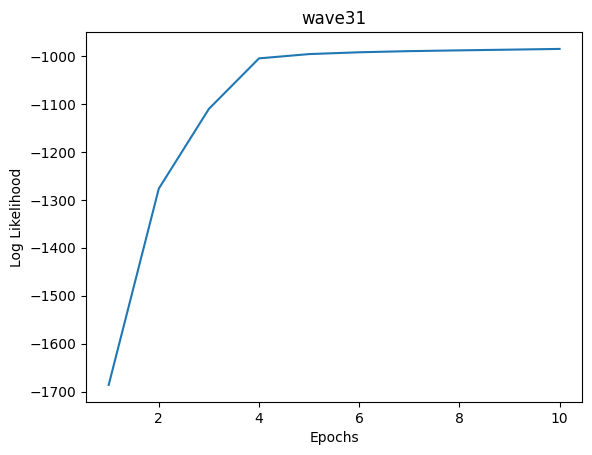

In [949]:
def save_parameters(gesture_name, A, B, pi):
    # Create directory if it does not exist
    directory = f'Data/Saved_Parameters/{gesture_name}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save parameters to file
    np.save(os.path.join(directory, 'A.npy'), A)
    np.save(os.path.join(directory, 'B.npy'), B)
    np.save(os.path.join(directory, 'pi.npy'), pi)

def train_all_models(num_epochs, N, M):
    for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
        # Load the data for each gesture
        fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
        file_name, file_extension = os.path.splitext(fname)
        path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
        gesture_data = load_file(path)
        time_data = gesture_data[:, 0][:, np.newaxis]
        acceleration_data = gesture_data[:, 1:]

        # Discretize the gesture data using kmeans
        O = KMeans(n_clusters=M).fit_predict(acceleration_data)

        # Initialize parameters
        A = init_a_matrix(N)
        B = init_b_matrix(N, M)
        pi = init_pi_matrix(N)

        # Train each model
        A, B, pi = train_model(file_name, num_epochs, N, M, A, B, pi, O)

        # Save model parameters
        save_parameters(file_name, A, B, pi)

train_all_models(10, 10, 50)

In [950]:
def load_parameters(gesture_name):
    directory = f'Data/Saved_Parameters/{gesture_name}'

    # Load saved parameters
    A = np.load(os.path.join(directory, 'A.npy'))
    B = np.load(os.path.join(directory, 'B.npy'))
    pi = np.load(os.path.join(directory, 'pi.npy'))

    return A, B, pi

In [951]:
def test_models():
    M = 50
    N = 10

    for j in range(len(os.listdir("Data/ECE5242Proj2-test-selected/"))):
        # Load and discretize the test data
        test_fname = os.listdir("Data/ECE5242Proj2-test-selected/")[j]
        test_file_name, file_extension = os.path.splitext(test_fname)
        path = os.path.join("Data/ECE5242Proj2-test-selected/", test_fname)
        gesture_data = load_file(path)
        time_data = gesture_data[:, 0][:, np.newaxis]
        acceleration_data = gesture_data[:, 1:]

        # Discretize the test data using kmeans
        O = KMeans(n_clusters=M).fit_predict(acceleration_data)
        print(f"{test_file_name} Predictions:")
        log_likelihoods = []
        
        for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
            # Load the trained lambda parameters for each gesture
            fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
            file_name, file_extension = os.path.splitext(fname)
            A, B, pi = load_parameters(file_name)

            # Run through forward pass to get predictions
            model = HMM(N, M, A, B, pi, O)
            _, c = model.forward()
            log_likelihood = -np.sum(np.log(c))
            log_likelihoods.append((file_name, log_likelihood))

        sorted_list = sorted(log_likelihoods, key=lambda x: x[1], reverse=True)
        print("My Prediction: ", sorted_list[0])
        print("Top 3 predictions: ", sorted_list[:3])
        print("\n")

test_models()

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test7 Predictions:
My Prediction:  ('eight31', -8293.768551524587)
Top 3 predictions:  [('eight31', -8293.768551524587), ('circle31', -9598.513944981605), ('wave31', -9723.136878346719)]




/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test6 Predictions:
My Prediction:  ('beat3_31', -7369.519970899292)
Top 3 predictions:  [('beat3_31', -7369.519970899292), ('eight31', -10764.551071030086), ('beat4_31', -11409.219651969826)]




/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test4 Predictions:
My Prediction:  ('circle31', -7839.730349955667)
Top 3 predictions:  [('circle31', -7839.730349955667), ('beat3_31', -8272.70314807599), ('wave31', -10270.529458359073)]




/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test5 Predictions:
My Prediction:  ('eight31', -5851.773716517873)
Top 3 predictions:  [('eight31', -5851.773716517873), ('inf31', -6403.4283895561075), ('beat4_31', -7246.300502318098)]


test1 Predictions:
My Prediction:  ('inf31', -4703.1540514201915)
Top 3 predictions:  [('inf31', -4703.1540514201915), ('beat4_31', -6249.676491364458), ('circle31', -6477.193569309484)]




/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test2 Predictions:
My Prediction:  ('beat3_31', -10694.000365535241)
Top 3 predictions:  [('beat3_31', -10694.000365535241), ('circle31', -10813.10177127596), ('beat4_31', -13822.404130020368)]




/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test3 Predictions:
My Prediction:  ('beat3_31', -4996.700310755257)
Top 3 predictions:  [('beat3_31', -4996.700310755257), ('inf31', -8394.11458892704), ('circle31', -9947.653076801234)]




/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test8 Predictions:
My Prediction:  ('circle31', -8741.721207563452)
Top 3 predictions:  [('circle31', -8741.721207563452), ('inf31', -8969.532428149845), ('wave31', -9137.539242490753)]


